# 第 7 章 双线性模型

从本章开始，我们介绍参数化模型中的非线性模型。在前几章中，我们介绍了线性回归与逻辑斯谛回归模型。这两个模型都有一个共同的特征：包含线性预测因子$\boldsymbol\theta^\mathrm{T}\boldsymbol x$。将该因子看作$\boldsymbol x$的函数，如果输入$\boldsymbol x$变为原来的$\lambda$倍，那么输出为$\boldsymbol\theta^\mathrm{T}(\lambda \boldsymbol x) = \lambda \boldsymbol\theta^\mathrm{T} \boldsymbol x$，也变成原来的$\lambda$ 倍。在第6章的扩展阅读中，我们将这一类模型都归为广义线性模型。然而，此类模型所做的线性假设在许多任务上并不适用，我们需要其他参数假设来导出更合适的模型。本章首先讲解在推荐系统领域很常用的双线性模型（bilinear model）。

双线性模型虽然名称中包含“线性模型”，但并不属于线性模型或广义线性模型，其正确的理解应当是“双线性”模型。在数学中，双线性的含义为，二元函数固定任意一个自变量时，函数关于另一个自变量线性。具体来说，二元函数$f \colon \mathbb{R}^n \times \mathbb{R}^m \to \mathbb{R}^l$是双线性函数，当且仅当对任意$\boldsymbol u, \boldsymbol v \in \mathbb{R}^n, \boldsymbol s, \boldsymbol t \in \mathbb{R}^m, \lambda \in \mathbb{R}$都有：

1. $f(\boldsymbol u, \boldsymbol s + \boldsymbol t) = f(\boldsymbol u, \boldsymbol s) + f(\boldsymbol u, \boldsymbol t)$
1. $f(\boldsymbol u, \lambda \boldsymbol s) = \lambda f(\boldsymbol u, \boldsymbol s)$
1. $f(\boldsymbol u + \boldsymbol v, \boldsymbol s) = f(\boldsymbol u, \boldsymbol s) + f(\boldsymbol v, \boldsymbol s)$
1. $f(\lambda \boldsymbol u, \boldsymbol s) = \lambda f(\boldsymbol u, \boldsymbol s)$

最简单的双线性函数的例子是向量内积$\langle \cdot, \cdot \rangle$，我们按定义验证前两条性质：

- $\small\langle \boldsymbol u, \boldsymbol s + \boldsymbol t \rangle = \sum_i u_i(s_i+t_i) = \sum_i(u_is_i + u_it_i) = \sum_i u_is_i + \sum_i u_it_i = \langle \boldsymbol u,\boldsymbol s \rangle + \langle \boldsymbol u, \boldsymbol t\rangle$
- $\small\langle \boldsymbol u, \lambda \boldsymbol s \rangle = \sum_i u_i(\lambda s_i) = \lambda \sum_i u_is_i = \lambda \langle \boldsymbol u, \boldsymbol s \rangle$

后两条性质由对称性，显然也是成立的。而向量的加法就不是双线性函数。虽然加法满足第1、3条性质，但对第2条，如果$\boldsymbol u \neq \boldsymbol 0$且$\lambda\neq 1$，则有：

$$
\boldsymbol u + \lambda \boldsymbol s \neq \lambda (\boldsymbol u + \boldsymbol s)
$$

与线性模型类似，双线性模型并非指模型整体具有双线性性质，而是指其包含双线性因子。该特性赋予模型拟合一些非线性数据模式的能力，从而得到更加精准预测性能。接下来，我们以推荐系统场景为例，介绍两个基础的双线性模型：矩阵分解模型和因子分解机。

## 7.1 矩阵分解

矩阵分解（matrix factorization，MF）$^{[1]}$是推荐系统中评分预测（rating prediction）的常用模型，其任务为根据用户和商品已有的评分来预测用户对其他商品的评分。为了更清晰地解释MF模型的任务场景，我们以用户对电影的评分为例进行详细说明。如图7-1所示，设想有 $N$ 个用户和 $M$ 部电影，每个用户对一些电影按自己的喜好给出了评分。现在，我们的目标是需要为用户从他没有看过的电影中，向他推荐几部他最有可能喜欢看的电影。理想情况下，如果这个用户对所有电影都给出了评分，那么这个任务就变为从已有评分的电影中进行推荐——直接按照用户打分的高低排序。但实际情况下，在浩如烟海的电影中，用户一般只对很小一部分电影做了评价。因此，我们需要从用户已经做出的评价中推测用户为其他电影的打分，再将电影按推测的打分排序，从中选出最高的几部推荐给该用户。

<img src=user_item.drawio.png width=60% alt=user_item>

图 7-1 用户对电影的评分矩阵

我们继续从生活经验出发来思考这一问题。假设某用户为一部电影打了高分，那么可以合理猜测，该用户喜欢这部电影的某些特征。例如，电影的类型是悬疑、爱情、战争或是其他种类；演员、导演和出品方分别是哪些；叙述的故事发生在什么年代；时长是多少，等等。假如我们有一个电影特征库，可以将每部电影用一个特征向量表示。向量的每一维代表一种特征，值代表电影具有这一特征的程度。同时，我们还可以构建一个用户画像库，包含每个用户更偏好哪些类型的特征，以及偏好的程度。假设特征的个数是$d$，那么所有电影的特征构成的矩阵是$\boldsymbol P \in \mathbb{R}^{M \times d}$，用户喜好构成的矩阵是$\boldsymbol Q \in \mathbb{R}^{N \times d}$。图7-2给出了两个矩阵的示例。

<img src=user_item_feat.drawio.png width=60% alt=user_item_feat>

图 7-2 电影和用户的隐变量矩阵

需要说明的是，我们实际上分解出的矩阵只是某种交互结果背后的隐变量，并不一定对应真实的特征。这样，我们就把一个用户与电影交互的矩阵拆分成了用户、电影两个矩阵，并且这两个矩阵中包含了更多的信息。最后，用这两个矩阵的乘积$\boldsymbol R = \boldsymbol P^\mathrm{T} \boldsymbol Q$可以还原出用户对电影的评分。即使用户对某部电影并没有打分，我们也能通过矩阵乘积，根据用户喜欢的特征和该电影具有的特征，预测出用户对电影的喜好程度。


---

> **小故事**：矩阵分解和下面要介绍的因子分解机都属于推荐系统（recommender system）领域的算法。我们在日常使用软件、浏览网站的时候，软件或网站会记录下来我们感兴趣的内容，并在接下来更多地为我们推送同类型的内容。例如，如果我们在购物网站上浏览过牙刷，它就可能再给我们推荐牙刷、毛巾、脸盆等等相关性比较大的商品，这就是推荐系统的作用。推荐系统希望根据用户的特征、商品的特征、用户和商品的交互历史，为用户做出更符合个人喜好的个性化推荐，提高用户的浏览体验，同时为公司带来更高的经济效益。
> 
> 机器学习界开始大量关注推荐系统任务源自美国奈飞电影公司（Netflix）于2006年举办的世界范围的推荐系统算法大赛。该比赛旨在探寻一种算法能更加精确地预测48万名用户对1.7万部电影的打分，如果某个参赛队伍给出的评分预测精度超过了基线算法10%，就可以获得100万美元的奖金。该竞赛在1年来吸引了来自全球186个国家的超过4万支队伍的参加，经过3年的“马拉松”竞赛，最终由一支名为BellKor's Pragmatic Chaos的联合团队摘得桂冠。而团队中时任雅虎研究员的耶胡达·科伦（Yehuda Koren）则在后来成为了推荐系统领域最为著名的科学家之一，他使用的基于矩阵分解的双线性模型则成为了那个时代推荐系统的主流模型[1]。

---

实际上，我们通常能获取到的并不是$\boldsymbol P$和$\boldsymbol Q$，而是打分的结果$\boldsymbol R$。并且由于一个用户只会对极其有限的一部分电影打分，矩阵$\boldsymbol R$是非常稀疏的，绝大多数元素都是空白。因此，我们需要从$\boldsymbol R$有限的元素中推测出用户的喜好$\boldsymbol P$和电影的特征$\boldsymbol Q$。MF 模型利用矩阵分解的技巧完成了这一任务。设第$i$个用户的偏好向量是$\boldsymbol p_i$，第$j$部电影的特征向量是$\boldsymbol q_j$，其维度都是特征数$d$。MF假设用户$i$对电影$j$的评分$r_{ij}$是用户偏好与电影特征的内积，即$r_{ij} = \boldsymbol p_i^\mathrm{T}\boldsymbol q_j$。在本章开始已经讲过，向量内积是双线性函数，这也是MF模型属于双线性模型的原因。

既然MF的目标是通过特征还原评分矩阵$\boldsymbol R$，我们就以还原结果和$\boldsymbol R$中已知部分的差距作为损失函数。记$I_{ij} = \mathbb{I}(r_{ij}\text{ 存在})$，即当用户为电影打过分时$I_{ij}$为$1$，否则为$0$。那么损失函数可以写为：
$$
J(\boldsymbol P, \boldsymbol Q) = \sum_{i=1}^N\sum_{j=1}^M I_{ij}\mathcal{L}(\boldsymbol p_i^\mathrm{T}\boldsymbol q_j, r_{ij})
$$
式中，$\mathcal{L}(\boldsymbol p_i^\mathrm{T}\boldsymbol q_j, r_{ij})$是模型预测和真实值之间的损失。一般情况下，我们就选用最简单的MSE作为损失，那么优化目标为：
$$
\min_{\boldsymbol P, \boldsymbol Q}  J(\boldsymbol P, \boldsymbol Q) = \frac12\sum_{i=1}^N\sum_{j=1}^M I_{ij} (\boldsymbol p_i^\mathrm{T}\boldsymbol q_j - r_{ij})^2
$$
再加入对$\boldsymbol P$和$\boldsymbol Q$的$L_2$正则化约束，就得到总的优化目标：
$$
\min_{\boldsymbol P, \boldsymbol Q}  J(\boldsymbol P, \boldsymbol Q) = \frac12\sum_{i=1}^N\sum_{j=1}^M I_{ij} \left((\boldsymbol p_i^\mathrm{T}\boldsymbol q_j - r_{ij})^2 + \lambda(\|\boldsymbol p_i\|^2 +\|\boldsymbol q_j\|^2)\right)
$$
需要注意，这里的$L_2$约束并非对整个矩阵$\boldsymbol P$或者$\boldsymbol Q$而言。我们知道，正则化的目的是通过限制参数的规模来约束模型的复杂度，使模型的复杂度与数据中包含的信息相匹配。以用户为例，假设不同用户直接的评分是独立的。如果用户甲给10部电影打了分，用户乙给2部电影打了分，那么数据中关于甲的信息就比乙多。反映到正则化上，对甲的参数的约束强度也应当比乙大。因此，总损失函数中$\boldsymbol p_i$的正则化系数是$\frac{\lambda}{2}\sum_{j=1}^M I_{ij}$，在$\frac{\lambda}{2}$的基础上又乘以用户$i$评分的数量。对电影向量$\boldsymbol q_j$也是同理。上式对$\boldsymbol p_{ik}$和$\boldsymbol q_{jk}$的梯度分别为：
$$
\begin{aligned}
\nabla_{\boldsymbol p_{ik}} J(\boldsymbol P, \boldsymbol Q) &= I_{ij} \left((\boldsymbol p_i^\mathrm{T}\boldsymbol q_j - r_{ij})\boldsymbol q_{jk} + \lambda\boldsymbol p_{ik} \right) \\
\nabla_{\boldsymbol q_{jk}} J(\boldsymbol P, \boldsymbol Q) &= I_{ij} \left((\boldsymbol p_i^\mathrm{T}\boldsymbol q_j - r_{ij})\boldsymbol p_{ik} + \lambda\boldsymbol q_{jk} \right)
\end{aligned}
$$
可以发现，上面$\boldsymbol p_{ik}$梯度中含有$\boldsymbol q_{jk}$，而$\boldsymbol q_{jk}$的梯度中含有$\boldsymbol p_{ik}$，两者互相包含，这是由双线性函数的性质决定的，也是双线性模型的一个重要特点。

## 7.2 动手实现矩阵分解

下面，我们来动手实现矩阵分解模型。我们选用的数据集是推荐系统中的常用数据集MovieLens，其包含从电影评价网站MovieLens中收集的真实用户对电影的打分信息。简单起见，我们采用其包含来自943个用户对1682部电影的10万条样本的版本MovieLens-100k。我们对原始的数据进行了一些处理，现在数据集的每一行有3个数，依次表示用户编号$i$、电影编号$j$、用户对电影的打分$r_{ij}$，其中$1\le r_{ij}\le5$且三者都是整数。表7-1展示了数据集中的3个样本，读者也可以从网站上下载更大的数据集，测试模型的预测效果。

表 7-1 MovieLens数据集示例

|用户编号|电影编号|评分|
|:-:|:-:|:-:|
|196|242|3|
|186|302|3|
|22|377|1|

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

data = np.loadtxt('movielens_100k.csv', delimiter=',', dtype=int)
print('数据集大小：', len(data))
# 用户和电影都是从1开始编号的，我们将其转化为从0开始
data[:, :2] = data[:, :2] - 1

# 计算用户和电影数量
users = set()
items = set()
for i, j, k in data:
    users.add(i)
    items.add(j)
user_num = len(users)
item_num = len(items)
print(f'用户数：{user_num}，电影数：{item_num}')

# 设置随机种子，划分训练集与测试集
np.random.seed(0)

ratio = 0.8
split = int(len(data) * ratio)
np.random.shuffle(data)
train = data[:split]
test = data[split:]

# 统计训练集中每个用户和电影出现的数量，作为正则化的权重
user_cnt = np.bincount(train[:, 0], minlength=user_num)
item_cnt = np.bincount(train[:, 1], minlength=item_num)
print(user_cnt[:10])
print(item_cnt[:10])

# 用户和电影的编号要作为下标，必须保存为整数
user_train, user_test = train[:, 0], test[:, 0]
item_train, item_test = train[:, 1], test[:, 1]
y_train, y_test = train[:, 2], test[:, 2]

数据集大小： 100000
用户数：943，电影数：1682
[215  47  42  19 139 170 320  47  18 156]
[371 109  70 172  70  21 308 158 240  68]


接下来，我们将MF模型定义成类，在其中实现梯度计算方法。根据上面的推导，模型的参数是用户喜好$\boldsymbol P \in \mathbb{R}^{N\times d}$和电影特征$\boldsymbol Q \in \mathbb{R}^{M \times d}$，其中特征数$d$是我们自己指定的超参数。在参数初始化部分，考虑到最终电影的得分都是正数，我们将参数都初始化为1。

In [8]:
class MF:
    
    def __init__(self, N, M, d):
        # N是用户数量，M是电影数量，d是特征维度
        # 定义模型参数
        self.user_params = np.ones((N, d))
        self.item_params = np.ones((M, d))
        
    def pred(self, user_id, item_id):
        # 预测用户user_id对电影item_id的打分
        # 获得用户偏好和电影特征
        user_param = self.user_params[user_id]
        item_param = self.item_params[item_id]
        # 返回预测的评分
        rating_pred = np.sum(user_param * item_param, axis=1)
        return rating_pred
    
    def update(self, user_grad, item_grad, lr):
        # 根据参数的梯度更新参数
        self.user_params -= lr * user_grad
        self.item_params -= lr * item_grad

下面定义训练函数，以SGD算法对MF模型的参数进行优化。对于回归任务来说，我们仍然以MSE作为损失函数，RMSE作为的评价指标。在训练的同时，我们将其记录下来，供最终绘制训练曲线使用。

In [3]:
def train(model, learning_rate, lbd, max_training_step, batch_size):
    train_losses = []
    test_losses = []
    batch_num = int(np.ceil(len(user_train) / batch_size))
    with tqdm(range(max_training_step * batch_num)) as pbar:
        for epoch in range(max_training_step):
            # 随机梯度下降
            train_rmse = 0
            for i in range(batch_num):
                # 获取当前批量
                st = i * batch_size
                ed = min(len(user_train), st + batch_size)
                user_batch = user_train[st: ed]
                item_batch = item_train[st: ed]
                y_batch = y_train[st: ed]
                # 计算模型预测
                y_pred = model.pred(user_batch, item_batch)
                # 计算梯度
                P = model.user_params
                Q = model.item_params
                errs = y_batch - y_pred
                P_grad = np.zeros_like(P)
                Q_grad = np.zeros_like(Q)
                for user, item, err in zip(user_batch, item_batch, errs):
                    P_grad[user] = P_grad[user] - err * Q[item] + lbd * P[user]
                    Q_grad[item] = Q_grad[item] - err * P[user] + lbd * Q[item]
                model.update(P_grad / len(user_batch), Q_grad / len(user_batch), learning_rate)
                
                train_rmse += np.mean(errs ** 2)
                # 更新进度条
                pbar.set_postfix({
                    'Epoch': epoch,
                    'Train RMSE': f'{np.sqrt(train_rmse / (i + 1)):.4f}',
                    'Test RMSE': f'{test_losses[-1]:.4f}' if test_losses else None
                })
                pbar.update(1)

            # 计算测试集上的RMSE
            train_rmse = np.sqrt(train_rmse / len(user_train))
            train_losses.append(train_rmse)
            y_test_pred = model.pred(user_test, item_test)
            test_rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))
            test_losses.append(test_rmse)
    
    return train_losses, test_losses

最后，我们定义超参数，并实现MF模型的训练部分，并将损失随训练的变化曲线绘制出来。

In [4]:
# 超参数
feature_num = 16 # 特征数
learning_rate = 0.1 # 学习率
lbd = 1e-4 # 正则化强度
max_training_step = 30
batch_size = 64 # 批量大小

# 建立模型
model = MF(user_num, item_num, feature_num)
# 训练部分
train_losses, test_losses = train(model, learning_rate, lbd, 
    max_training_step, batch_size)

plt.figure()
x = np.arange(max_training_step) + 1
plt.plot(x, train_losses, color='blue', label='train loss')
plt.plot(x, test_losses, color='red', ls='--', label='test loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

 88%|██████████████▉  | 32883/37500 [01:16<00:09, 488.84it/s, Epoch=26, Train RMSE=0.9871, Test RMSE=1.0160]

为了直观地展示模型效果，我们输出一些模型在测试集中的预测结果与真实结果进行对比。上面我们训练得到的模型在测试集上的RMSE大概是1左右，所以这里模型预测的评分与真实评分大致也差1。

In [5]:
y_test_pred = model.pred(user_test, item_test)
print(y_test_pred[:10]) # 把张量转换为numpy数组
print(y_test[:10])

## 7.3  因子分解机

本节我们介绍推荐系统中用户行为预估的另一个常用模型：因子分解机（factorization machines，FM）$^{[2]}$。FM的应用场景与MF有一些区别，MF的目标是从交互的结果中计算出用户和物品的特征；而FM则正好相反，希望通过物品的特征和某个用户点击这些物品的历史记录，预测该用户点击其他物品的概率，即点击率（click through rate，CTR）。由于被点击和未被点击是一个二分类问题，CTR预估可以用逻辑斯谛回归模型来解决。在逻辑斯谛回归中，线性预测子$\boldsymbol\theta^\mathrm{T} \boldsymbol x$为数据中的每一个特征$x_i$赋予权重$\theta_i$，由此来判断数据的分类。然而，这样的线性参数化假设中，输入的不同特征$x_i$与$x_j$之间并没有运算，相当于假设不同特征之间是独立的。而在现实中，输入数据的不同特征之间有可能存在关联。例如，假设我们将一张照片中包含的物品作为其特征，那么“红灯笼”与“对联”这两个特征就很可能不是独立的，因为它们都是与春节相关联的意象。因此，作为对线性的逻辑斯谛回归模型的改进，我们进一步引入双线性部分，将输入的不同特征之间的联系也考虑进来。改进后的预测函数为：

$$
\hat y(\boldsymbol x) = \theta_0 + \sum_{i=1}^d \theta_i x_i + \sum_{i=1}^{d-1}\sum_{j=i+1}^d w_{ij}x_ix_j
$$

其中，$\theta_0$是常数项，$w_{ij}$是权重。上式的第二项将所有不同特征$x_i$与$x_j$相乘，从而可以通过权重$w_{ij}$调整特征组合$(i,j)$对预测结果的影响。将上式改写为向量形式，为：
$$
\hat y(\boldsymbol x) = \theta_0 + \boldsymbol\theta^\mathrm{T} \boldsymbol x + \frac12 \boldsymbol x^\mathrm{T} \boldsymbol W \boldsymbol x
$$

式中，矩阵$\boldsymbol W$是对称的，即$w_{ij} = w_{ji}$。此外，由于我们已经考虑了单独特征的影响，所以不需要将特征与其自身进行交叉，引入$x_i^2$项，从而$\boldsymbol W$的对角线上元素都为$0$。读者可以自行验证，形如$f(\boldsymbol x, \boldsymbol y) = \boldsymbol x^\mathrm{T} \boldsymbol A \boldsymbol y$的函数是双线性函数。双线性模型由于考虑了不同特征之间的关系，理论上比线性模型要更准确。然而，在实际应用中，该方法面临着稀疏特征的挑战。

在用向量表示某一事物的离散特征时，一种常用的方法是独热编码（one-hot encoding）。这一方法中，向量的每一维都对应特征的一种取值，样本所具有的特征所在的维度值为1，其他维度为0。如图7-3所示，某物品的产地是北京、上海、广州、深圳其中之一，为了表示该物品的产地，我们将其编码为4维向量，4个维度依次对应产地北京、上海、广州、深圳。当物品产地为北京时，其特征向量就是$(1,0,0,0)$；物品产地为上海时，其特征向量就是$(0,1,0,0)$。如果物品有多个特征，就把每个特征编码成的向量依次拼接起来，形成多域独热编码（multi-field one-hot encoding）。假如某种食品产地是上海、生产日期在2月份、食品种类是乳制品，那么它的编码就如图7-3所示。

<img src="mfoh.drawio.png" width="100%" alt="mfoh">

图 7-3 多域独热编码示意


像这样的独热特征向量往往维度非常高，但只有少数几个位置是1，其他位置都是0，稀疏程度很高。当我们训练上述的模型时，需要对参数$w_{ij}$求导，结果为$\displaystyle \frac{\partial \hat y}{\partial w_{ij}} = x_ix_j$。由于特征向量的稀疏性，大多数情况下都有$x_ix_j=0$，无法对参数$w_{ij}$进行更新。为了解决这一问题，Steffen Rendle提出了因子分解机模型。该方法将权重矩阵$\boldsymbol W$分解成$\boldsymbol W = \boldsymbol V \boldsymbol V^\mathrm{T}$，其中$\boldsymbol V \in \mathbb{R}^{d \times k}$。根据矩阵分解的相关理论，当$\boldsymbol W$满足某些性质且$k$足够大时，我们总可以找到分解矩阵$\boldsymbol V$。即使条件不满足，我们也可以用近似分解$\boldsymbol W \approx \boldsymbol V\boldsymbol V^\mathrm{T}$来代替。设$\boldsymbol V$的行向量是$\boldsymbol v_1, \ldots, \boldsymbol v_d$，也即是对每个特征$x_i$配一个$k$维实数向量$\boldsymbol v_i$，用矩阵乘法直接计算可以得到$w_{ij} = \langle \boldsymbol v_i, \boldsymbol v_j \rangle$，这样模型的预测函数可以写为：
$$
\hat y(\boldsymbol x) = \theta_0 + \boldsymbol\theta^\mathrm{T} \boldsymbol x + \sum_{i=1}^{d-1}\sum_{j=i+1}^d \langle \boldsymbol v_i, \boldsymbol v_j \rangle x_ix_j
$$

这时，再对参数$\boldsymbol v_s$求梯度的结果为：
$$
\begin{aligned}
\nabla_{\boldsymbol v_s} \hat y &= \nabla_{\boldsymbol v_s} \left(\sum_{i=1}^{d-1}\sum_{j=i+1}^d \langle \boldsymbol v_i, \boldsymbol v_j \rangle x_ix_j \right)\\
&= \nabla_{\boldsymbol v_s} \left( \sum_{j=s+1}^d \langle \boldsymbol v_s, \boldsymbol v_j\rangle x_sx_j + \sum_{i=1}^{s-1} \langle \boldsymbol v_i, \boldsymbol v_s \rangle x_ix_s \right) \\
&= x_s \sum_{j=s+1}^d x_j\boldsymbol v_j + x_s \sum_{i=1}^{s-1} x_i \boldsymbol v_i \\
&= x_s \sum_{i=1}^d x_i \boldsymbol v_i - x_s^2 \boldsymbol v_s
\end{aligned}
$$

上面的计算过程中，为了简洁，我们采用了不太严谨的写法，当$s=1$或$s=d$时会出现求和下界大于上界的情况。此时我们规定求和的结果为零。如果要完全展开，只需要做类似于$\sum_{j=s+1}^d \langle \boldsymbol v_s, \boldsymbol v_j \rangle x_sx_j$变为$\sum_{j=s}^d \langle \boldsymbol v_s, \boldsymbol v_j \rangle x_sx_j - \langle \boldsymbol v_s, \boldsymbol v_s \rangle x_s^2$的裂项操作即可。从该结果中可以看出，只要$x_s \neq 0$，参数$\boldsymbol v_s$的梯度就不为零，可以用梯度相关的算法对其更新。因此，即使特征向量$\boldsymbol x$非常稀疏，FM模型也可以正常进行训练。

至此，我们的模型还存在一个问题。双线性模型考虑不同特征之间乘积的做法，虽然提升了模型的能力，但也引入了额外的计算开销。对一个样本来说，线性模型需要计算$\boldsymbol\theta^\mathrm{T} \boldsymbol x$，时间复杂度为$O(d)$；而我们的模型需要计算每一对特征$(x_i,x_j)$的乘积，以及参数$\boldsymbol v_i$与$\boldsymbol v_j$的内积，时间复杂度为$O(kd^2)$。上面已经讲过，多热编码的特征向量维度常常特别高，因此这一时间开销是相当巨大的。但是，我们可以对上面的公式做一些变形，改变计算顺序来降低时间复杂度。变形方式如下：
$$
\begin{aligned}
\sum_{i=1}^{d-1}\sum_{j=i+1}^d \langle \boldsymbol v_i, \boldsymbol v_j \rangle x_ix_j &= \frac{1}{2} \left( \sum_{i=1}^d\sum_{j=1}^d \langle \boldsymbol v_i, \boldsymbol v_j \rangle x_ix_j - \sum_{i=1}^d \langle \boldsymbol v_i, \boldsymbol v_i \rangle x_i^2 \right) \\
&= \frac{1}{2} \left( \sum_{i=1}^d\sum_{j=1}^d \langle x_i \boldsymbol v_{i}, x_j \boldsymbol v_{j} \rangle - \sum_{i=1}^d \langle x_i \boldsymbol v_i, x_i \boldsymbol v_i \rangle \right) \\
&= \frac12 \left\langle \sum_{i=1}^d x_i \boldsymbol v_i, \sum_{j=1}^d x_j \boldsymbol v_j\right\rangle - \frac12 \sum_{i=1}^d \langle x_i \boldsymbol v_i, x_i \boldsymbol v_i \rangle \\
&= \frac12 \sum_{l=1}^k \left(\sum_{i=1}^d v_{il}x_i \right)^2 - \frac12 \sum_{l=1}^k \sum_{i=1}^d v_{il}^2x_i^2
\end{aligned}
$$

在变形的第二步和第三步，我们利用了向量内积的双线性性质，将标量$x_i, x_j$以及求和都移到内积中去。最后的结果中只含有两重求和，外层为$k$次，内层为$d$次，因此整体的时间复杂度为$O(kd)$。这样，FM的时间复杂度关于特征规模$d$的增长从平方变为线性，得到了大幅优化。至此，FM的预测公式为：
$$
\hat y(\boldsymbol x) = \theta_0 + \sum_{i=1}^d \theta_i x_i + \frac12 \sum_{l=1}^k \left( \left( \sum_{i=1}^d v_{il}x_i \right)^2 - \sum_{i=1}^d v_{il}^2 x_i^2 \right)
$$

如果要做分类任务，只需要再加上softmax函数即可。

在上面的模型中，我们只考虑了两个特征之间的组合，因此该FM也被称为二阶FM。如果进一步考虑多个特征的组合，如$x_ix_jx_k$，就可以得到高阶的FM模型。由于高阶FM较为复杂，并且也不再是双线性模型，本书在此略去，感兴趣的读者可以自行查阅相关资料。

## 7.4 动手实现因子分解机

下面，我们来动手实现二阶FM模型。本节采用的数据集是为FM制作的示例数据集fm_dataset.csv，包含了某个用户浏览过的商品的特征，以及用户是否点击过这个商品。数据集的每一行包含一个商品，前24列是其特征，最后一列是0或1，分别表示用户没有或有点击该商品。我们的目标是根据输入特征预测用户在测试集上的行为，是一个二分类问题。我们先导入必要的模块和数据集并处理数据，将其划分为训练集和测试集。

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # sklearn中的评价指标函数库
from tqdm import tqdm

# 导入数据集
data = np.loadtxt('fm_dataset.csv', delimiter=',')

# 划分数据集
np.random.seed(0)
ratio = 0.8
split = int(ratio * len(data))
x_train = data[:split, :-1]
y_train = data[:split, -1]
x_test = data[split:, :-1]
y_test = data[split:, -1]
# 特征数
feature_num = x_train.shape[1]
print('训练集大小：', len(x_train))
print('测试集大小：', len(x_test))
print('特征数：', feature_num)

训练集大小： 800
测试集大小： 200
特征数： 24


接下来，我们将FM模型定义成类。与MF相同，我们在类中实现预测和梯度更新方法。

In [10]:
class FM:

    def __init__(self, feature_num, vector_dim):
        # vector_dim代表公式中的k，为向量v的维度
        self.theta0 = 0.0 # 常数项
        self.theta = np.zeros(feature_num) # 线性参数
        self.v = np.random.normal(size=(feature_num, vector_dim)) # 双线性参数
        self.eps = 1e-6 # 精度参数
        
    def _logistic(self, x):
        # 工具函数，用于将预测转化为概率
        return 1 / (1 + np.exp(-x))

    def pred(self, x):
        # 线性部分
        linear_term = self.theta0 + x @ self.theta
        # 双线性部分
        square_of_sum = np.square(x @ self.v)
        sum_of_square = np.square(x) @ np.square(self.v)
        # 最终预测
        y_pred = self._logistic(linear_term \
            + 0.5 * np.sum(square_of_sum - sum_of_square, axis=1))
        # 为了防止后续梯度过大，对预测值进行裁剪，将其限制在某一范围内
        y_pred = np.clip(y_pred, self.eps, 1 - self.eps)
        return y_pred
    
    def update(self, grad0, grad_theta, grad_v, lr):
        self.theta0 -= lr * grad0
        self.theta -= lr * grad_theta
        self.v -= lr * grad_v

对于分类任务，我们仍用MLE作为训练时的损失函数。在测试集上，我们采用AUC作为评价指标。由于我们在第6章中已经动手实现过AUC，简单起见，这里我们就直接使用sklearn中的函数直接计算AUC。我们用SGD进行参数更新，训练完成后，我们把训练过程中的准确率和AUC绘制出来。

In [11]:
# 超参数设置，包括学习率、训练轮数等
vector_dim = 16
learning_rate = 0.01
lbd = 0.05
max_training_step = 200
batch_size = 32

# 初始化模型
np.random.seed(0)
model = FM(feature_num, vector_dim)

train_acc = []
test_acc = []
train_auc = []
test_auc = []

with tqdm(range(max_training_step)) as pbar:
    for epoch in pbar:
        st = 0
        while st < len(x_train):
            ed = min(st + batch_size, len(x_train))
            X = x_train[st: ed]
            Y = y_train[st: ed]
            st += batch_size
            # 计算模型预测
            y_pred = model.pred(X)
            # 计算交叉熵损失
            cross_entropy = -Y * np.log(y_pred) \
                - (1 - Y) * np.log(1 - y_pred)
            loss = np.sum(cross_entropy)
            # 计算损失函数对y的梯度，再根据链式法则得到总梯度
            grad_y = (y_pred - Y).reshape(-1, 1)
            # 计算y对参数的梯度
            # 常数项
            grad0 = np.sum(grad_y * (1 / len(X) + lbd))
            # 线性项
            grad_theta = np.sum(grad_y * (X / len(X) \
                + lbd * model.theta), axis=0)
            # 双线性项
            grad_v = np.zeros((feature_num, vector_dim))
            for i, x in enumerate(X):
                # 先计算sum(x_i * v_i)
                xv = x @ model.v
                grad_vi = np.zeros((feature_num, vector_dim))
                for s in range(feature_num):
                    grad_vi[s] += x[s] * xv - (x[s] ** 2) * model.v[s]
                grad_v += grad_y[i] * grad_vi
            grad_v = grad_v / len(X) + lbd * model.v
            model.update(grad0, grad_theta, grad_v, learning_rate)

            pbar.set_postfix({
                '训练轮数': epoch,
                '训练损失': f'{loss:.4f}',
                '训练集准确率': train_acc[-1] if train_acc else None,
                '测试集准确率': test_acc[-1] if test_acc else None
            })
        # 计算模型预测的准确率和AUC
        # 预测准确率，阈值设置为0.5
        y_train_pred = (model.pred(x_train) >= 0.5)
        acc = np.mean(y_train_pred == y_train)
        train_acc.append(acc)
        auc = metrics.roc_auc_score(y_train, y_train_pred) # sklearn中的AUC函数
        train_auc.append(auc)

        y_test_pred = (model.pred(x_test) >= 0.5)
        acc = np.mean(y_test_pred == y_test)
        test_acc.append(acc)
        auc = metrics.roc_auc_score(y_test, y_test_pred) 
        test_auc.append(auc)
            
print(f'测试集准确率：{test_acc[-1]}，\t测试集AUC：{test_auc[-1]}')

100%|█| 200/200 [00:43<00:00,  4.61it/s, 训练轮数=199, 训练损失=11.3006, 训练集准确率=0.816, 测试集准确率=0.200 [00:00<?, ?it/s]

测试集准确率：0.79，	测试集AUC：0.7201320910484726


最后，我们把训练过程中在训练集和测试集上的精确率和AUC绘制出来，观察训练效果。

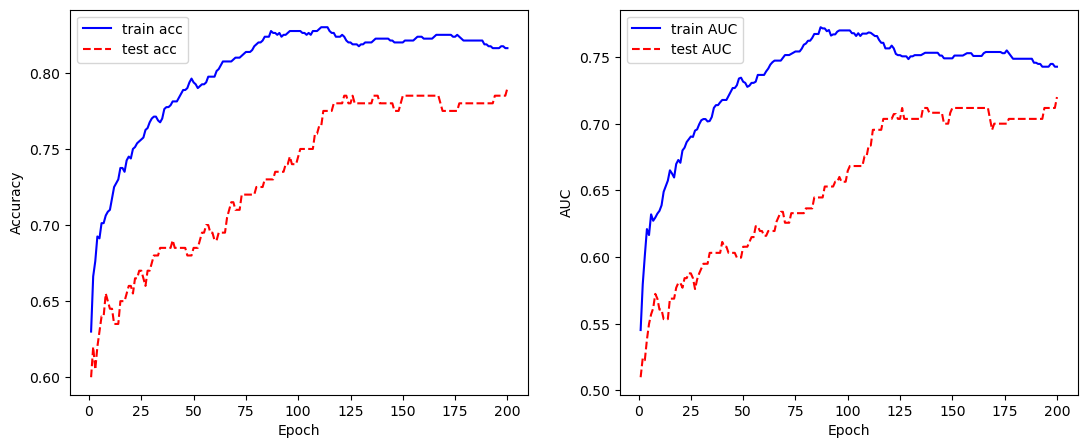

In [12]:
# 绘制训练曲线            
plt.figure(figsize=(13, 5))
x_plot = np.arange(len(train_acc)) + 1

plt.subplot(121)
plt.plot(x_plot, train_acc, color='blue', label='train acc')
plt.plot(x_plot, test_acc, color='red', ls='--', label='test acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(x_plot, train_auc, color='blue', label='train AUC')
plt.plot(x_plot, test_auc, color='red', ls='--', label='test AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

## 7.6 本章小结

本章介绍了双线性模型的来源和特点，以及与线性模型的区别。双线性模型通过引入满足双线性性质的函数，相比于线性模型提升了对特征间关系建模的能力，从而达到更好的预测效果。本章以因子分解机和概率矩阵分解两个推荐系统中的常用模型为例，具体讲解了双线性模型的应用，并动手实现了两个模型。MF模型和FM模型的应用场景不同。在FM中，用户的特征已知，我们希望挖掘特征与输出、特征与特征之间的关系；而在MF中，用户和物品的特征都是未知的，需要从模型训练得到。这两个模型都是目前推荐系统所用模型的基础，从它们改进和衍生的模型仍然有广泛应用。

## 习题

1. 以下关于双线性模型的说法，不正确的是： 
    A. 双线性模型考虑了特征之间的关联，比线性模型建模能力更强。 
    B. 在因子分解机中，因为引入了特征的乘积，只有特征$x_i$与$x_j$都不为零时才能更新参数$w_{ij}$。 
    C. 可以通过重新设置参数，把因子分解机中的常数项和一次项都合并到二次项里，得到更一般的表达式。 
    D. 在矩阵分解中，最优的特征数量$d$是超参数，不能通过公式推导出来。

1. 以下哪一个模型不是关于双线性模型： 
    A. $f(\theta_1, \theta_2)=\theta_1 \theta_2$。
    B. $f(\boldsymbol \theta_1, \boldsymbol \theta_2)=\langle \boldsymbol \theta_1, \boldsymbol\theta_2 \rangle$。
    C. $f(\theta_1, \theta_2)=0$。
    D. $f(\theta_1, \theta_2)=e^{\theta_1} e^{\theta_2}$。

1. 关于多域独热编码，思考其相比于如下编码方式的优势：针对每一个域，依次把其中的离散取值以自然数（以0开始）作为编码，在编码后每个域就对应一个自然数。例如图7-3中产地上海对应为1，深圳对应为3，生产月份2月对应为1，12月对应11，食品种类乳制品对应为0，图中的整个编码向量为$(1,2,\ldots,0)$。

1. 试修改MF的`pred(self, user_id, item_id)`函数，在模型预测中加入全局打分偏置、用户打分偏置和物品打分偏置，类似FM模型中的常数项部分，观察模型拟合性能指标的变化。

1. 试基于本章的MF代码，调试不同的超参数，包括$k$和$\lambda$，关注训练集和测试集的性能指标的改变，根据训练和测试的性能曲线，判定哪些超参数导致过拟合。

1.  试通过代码实验来验证双线性模型FM做回归或分类任务时，其优化目标相对参数是非凸的，也即是，设置不同的参数初始值，使用同样的SGD学习算法，最后参数会收敛到不同的位置。


## 拓展阅读：概率矩阵分解

概率矩阵分解（probabilistic matrix factorization，PMF）$^{[3]}$是另一种常用的双线性模型。与矩阵分解模型不同，它对用户给电影的评分$r_{ij}$的分布进行了先验假设，认为其满足正态分布：
$$
r_{ij} \sim \mathcal{N}(\boldsymbol p_i^\mathrm{T} \boldsymbol q_j, \sigma^2)
$$
其中$\sigma^2$是正态分布的方差，与用户和电影无关。注意，$\boldsymbol p_i$与$\boldsymbol q_j$都是未知的。记$I_{ij} = \mathbb{I}(r_{ij} \text{ 存在})$，即当用户$i$对电影$j$打过分时$I_{ij}=1$，否则$I_{ij}=0$。再假设不同的评分采样之间互相独立，那么，我们观测到的$\boldsymbol R$出现的概率是：
$$
P(\boldsymbol R | \boldsymbol P, \boldsymbol Q, \sigma) = \prod_{i=1}^N\prod_{j=1}^M p_\mathcal{N}(r_{ij}| \boldsymbol p_i^\mathrm{T} \boldsymbol q_j, \sigma^2)^{I_{ij}}
$$
这里，我们用$p_\mathcal{N}(x|\mu,\sigma^2)$表示正态分布$\mathcal{N}(\mu, \sigma^2)$的概率密度函数，其完整表达式为：
$$
p_\mathcal{N}(x|\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left( -\frac{(x-\mu)^2}{2\sigma^2} \right)
$$
对于那些空缺的$r_{ij}$，由于$I_{ij}=0$，$p_\mathcal{N}(r_{ij}|\boldsymbol p_i^\mathrm{T} \boldsymbol q_j, \sigma^2)^{I_{ij}}=1$，对连乘没有贡献，最终的概率只由已知部分计算得出。接下来，我们进一步假设用户的喜好$\boldsymbol p_i$和电影的特征$\boldsymbol q_j$都满足均值为$\boldsymbol 0$的正态分布，协方差矩阵分别为$\sigma_P^2\boldsymbol I$和$\sigma_Q^2 \boldsymbol I$，即：
$$
P(\boldsymbol P | \sigma_P) = \prod_{i=1}^N p_\mathcal{N}(\boldsymbol p_i| \boldsymbol 0, \sigma_P^2 \boldsymbol I), \quad P(\boldsymbol Q | \sigma_Q) = \prod_{j=1}^M p_\mathcal{N}(\boldsymbol q_j | \boldsymbol 0, \sigma_Q^2 \boldsymbol I)
$$

根据全概率公式$P(X,Y) = P(X|Y)P(Y)$，并注意到$\boldsymbol R$与$\sigma_P, \sigma_Q$无关，我们可以计算出$\boldsymbol P$与$\boldsymbol Q$的后验概率为：
$$
\small\begin{aligned}
P(\boldsymbol P, \boldsymbol Q | \boldsymbol R, \sigma, \sigma_P, \sigma_Q) &= \frac{P(\boldsymbol P, \boldsymbol Q, \boldsymbol R, \sigma, \sigma_P, \sigma_Q)}{P(\boldsymbol R, \sigma, \sigma_P, \sigma_Q)} \\
&= \frac{P(\boldsymbol R | \boldsymbol P, \boldsymbol Q, \sigma)P(\boldsymbol P, \boldsymbol Q | \sigma_P, \sigma_Q) P(\sigma, \sigma_P, \sigma_Q)}{P(\boldsymbol R, \sigma, \sigma_P, \sigma_Q)} \\
&= C \cdot P(\boldsymbol R | \boldsymbol P, \boldsymbol Q, \sigma)P(\boldsymbol P|\sigma_P)P(\boldsymbol Q|\sigma_Q) \\
&= C\prod_{i=1}^N\prod_{j=1}^M p_\mathcal{N}(r_{ij}| \boldsymbol p_i^\mathrm{T} \boldsymbol q_j, \sigma^2)^{I_{ij}} \cdot \prod_{i=1}^N p_\mathcal{N}(\boldsymbol p_i| \boldsymbol 0, \sigma_P^2 \boldsymbol I) \cdot \prod_{j=1}^M p_\mathcal{N}(\boldsymbol q_j | \boldsymbol 0, \sigma_Q^2 \boldsymbol I)
\end{aligned}
$$
其中$C$是常数。为了简化这一表达式，我们利用与MLE中相同的技巧，将上式取对数，从而把连乘变为求和：
$$
\begin{aligned}
\log P(\boldsymbol P, \boldsymbol Q | \boldsymbol R, \sigma, \sigma_P, \sigma_Q) &= \sum_{i=1}^N\sum_{j=1}^M I_{ij} \log p_\mathcal{N}(r_{ij} | \boldsymbol p_i^\mathrm{T} \boldsymbol q_j, \sigma^2) + \sum_{i=1}^N \log p_\mathcal{N}(\boldsymbol p_i| \boldsymbol 0, \sigma_P^2 \boldsymbol I) \\
&\quad+ \sum_{j=1}^M \log p_\mathcal{N}(\boldsymbol q_j | \boldsymbol 0, \sigma_Q^2 \boldsymbol I) + \log C
\end{aligned}
$$

再代入$p_\mathcal{N}$取对数后的表达式
$$
\log p_\mathcal{N}(x|\mu, \sigma^2) = -\frac12 \log (2\pi\sigma^2) - \frac{(x-\mu)^2}{2\sigma^2}
$$
计算得到
$$
\small\begin{aligned}
\log P(\boldsymbol P, \boldsymbol Q | \boldsymbol R, \sigma, \sigma_P, \sigma_Q) &= -\frac12 \log(2\pi\sigma^2) \sum_{i=1}^N\sum_{j=1}^M I_{ij} - \frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^M I_{ij}(r_{ij} - \boldsymbol p_i^\mathrm{T} \boldsymbol q_j)^2 \\
&\quad-\frac{Nd}{2} \log(2\pi\sigma_P^2) - \frac{1}{2\sigma_P^2}\sum_{i=1}^N \boldsymbol p_i^\mathrm{T} \boldsymbol p_i \\
&\quad-\frac{Md}{2} \log(2\pi\sigma_Q^2) - \frac{1}{2\sigma_Q^2}\sum_{j=1}^M \boldsymbol q_j^\mathrm{T} \boldsymbol q_j + \log C \\
&= -\frac{1}{\sigma^2} \left[\frac12 \sum_{i=1}^N\sum_{j=1}^M I_{ij}(r_{ij} - \boldsymbol p_i^\mathrm{T} \boldsymbol q_j)^2 + \frac{\lambda_P}{2} \lVert \boldsymbol P \lVert_F^2 + \frac{\lambda_Q}{2} \lVert \boldsymbol Q \lVert_F^2 \right] + C_1
\end{aligned}
$$

其中，$\lambda_P = \sigma^2/\sigma_P^2$，$\lambda_Q = \sigma^2 / \sigma_Q^2$，$C_1$是与参数$\boldsymbol P$和$\boldsymbol Q$无关的常数。根据最大似然的思想，我们应当最大化上面计算出的对数概率。因此，定义损失函数为：
$$
J(\boldsymbol P, \boldsymbol Q) = \frac12 \sum_{i=1}^N\sum_{j=1}^M I_{ij}(r_{ij} - \boldsymbol p_i^\mathrm{T} \boldsymbol q_j)^2 + \frac{\lambda_P}{2} \lVert \boldsymbol P \lVert_F^2 + \frac{\lambda_Q}{2} \lVert \boldsymbol Q \lVert_F^2
$$

于是，最大化对数概率就等价于最小化损失函数$J(\boldsymbol P, \boldsymbol Q)$。并且，这一损失函数恰好为目标值$r_{ij}$与参数内积$\boldsymbol p_i^\mathrm{T} \boldsymbol q_i$之间的平方损失，再加上$L_2$正则化的形式。由于向量内积是双线性函数，PMF模型也属于双线性模型的一种。

将损失函数对$\boldsymbol p_i$求导，得到：
$$
\nabla_{\boldsymbol p_i} J(\boldsymbol P, \boldsymbol Q) = \sum_{j=1}^M I_{ij}(r_{ij} - \boldsymbol p_i^\mathrm{T} \boldsymbol q_j) \boldsymbol q_j - \lambda_P \boldsymbol p_i
$$

令梯度为零，解得：
$$
\boldsymbol p_i = \left(\sum_{j=1}^MI_{ij}\boldsymbol q_j\boldsymbol q_j^\mathrm{T} + \lambda_P \boldsymbol I\right)^{-1} \left(\sum_{j=1}^M I_{ij}r_{ij}\boldsymbol q_j\right)
$$

在正则化约束一节中我们讲过，根据矩阵相关的理论，只要$\lambda_P$足够大，上式的第一项逆矩阵就总是存在。同理，对$\boldsymbol q_j$也有类似的结果。因此，我们可以通过如上形式的$J(\boldsymbol P, \boldsymbol Q)$来求解参数$\boldsymbol P$与$\boldsymbol Q$。在参数的高斯分布假设下，我们自然导出了带有$L_2$正则化的MF模型，这并不是偶然。我们会在第16章概率图模型中进一步阐释其中的原理。

## 参考文献

[1] 矩阵分解模型论文：Koren Y, Bell R, Volinsky C. Matrix factorization techniques for recommender systems[J]. Computer, 2009, 42(8): 30-37.

[2] 因子分解机论文：Rendle S. Factorization machines[C]//2010 IEEE International conference on data mining. IEEE, 2010: 995-1000.

[3] 概率矩阵分解论文：Mnih A, Salakhutdinov R R. Probabilistic matrix factorization[J]. Advances in neural information processing systems, 2007, 20.